# 木に基づく方法

In [6]:
# 以下のuserguide見ながら、まずはirisデータでファイルとノートブックへの出力を行う
# https://scikit-learn.org/stable/modules/tree.html#tree
from sklearn.datasets import load_iris
from sklearn import tree

clf = tree.DecisionTreeClassifier()
iris = load_iris()

clf = clf.fit(iris.data, iris.target)

In [7]:
# graphvizはpipだけじゃなくダウンロードする必要がある（https://teratail.com/questions/145650）
# http://ruby.kyoto-wu.ac.jp/info-com/Softwares/Graphviz/
import graphviz

# ファイルへの出力
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

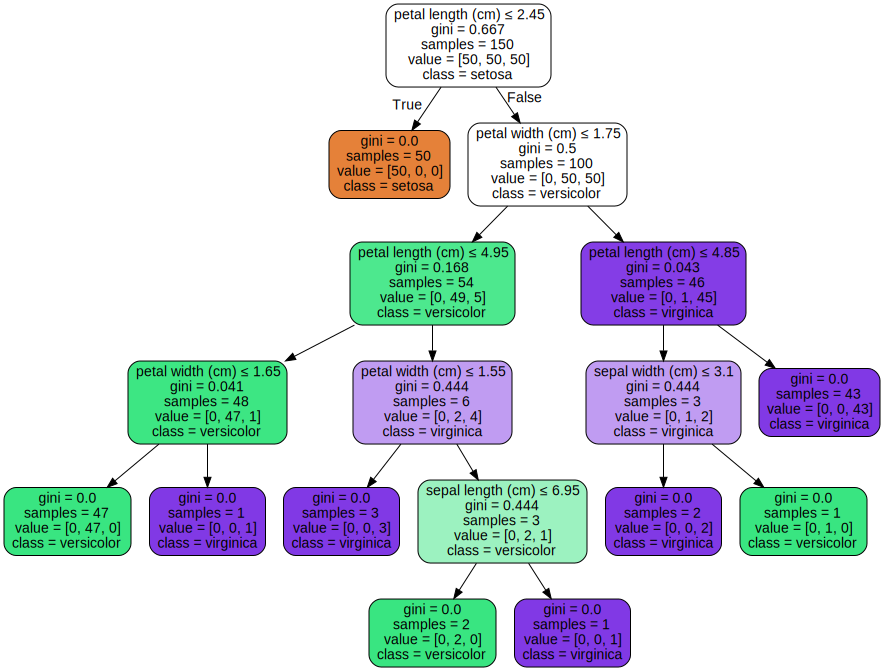

In [8]:
# ノートブックへの出力
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [25]:
# !pip install graphviz

## 決定木の基礎

### 回帰木

##### 回帰木を用いた野球選手の収入の予測

``Hitters``データセットにおいて``Years``（メジャーリーグ在籍年数）と``Hits``（前年のヒット数）に基づいて、野球選手の収入``Salary``を予測する。まず、``Salary``の値が欠損している観測値を削除し、対数変換を行って``Salary``の分布がより釣鐘型に近づくようにする（``Salary``の単位は千ドルである）。

In [77]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [11]:
df = pd.read_csv('Datasets/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


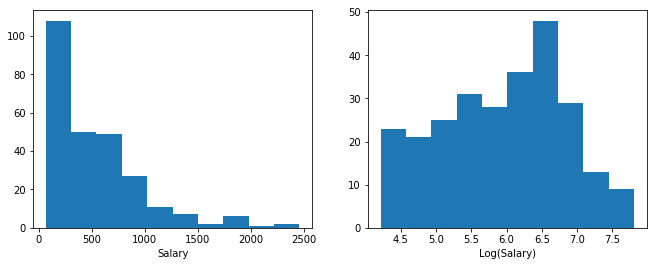

In [30]:
X = df[['Years', 'Hits']].values
y = np.log(df.Salary.values)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

図8.1はこのデータに当てはめた回帰木を示している。これは、木の頂点から始まってルールによって次第に分割されていく流れを表している。頂点における分割は、``Years<4.5``の観測値を左の枝に割り当てている。``Years<4.5``に該当する選手の予測年収は、これらの選手の収入の平均によって与えられる。これに該当する選手について、対数変換した収入の平均は$5.107$であるので、収入の平均は$1000 \times e^{5.107}=165174$ドルと予測される。``Years>=4.5``に該当する選手は右の枝に割り当てられており、このグループはさらに``Hits``によって再分割されている。全体として、気は選手を予測変数空間における3つの領域（在籍4年以下の選手、在籍5年以上で昨年のヒット数が118本未満の選手、在籍5年以上で昨年のヒット数が118本以上の選手）に層化あるいはセグメント化している。これらの3つの領域は、$R_1 = \{X|\mathrm{Years} < 4.5\}, R_2 = \{X|\mathrm{Years} \ge 4.5, \mathrm{Hits} < 117.5\}, R_3 = \{X|\mathrm{Years} \ge 4.5, \mathrm{Hits} \ge 117.5\}$と書くことができる。図8.2は``Years``と``Hits``の関数として、領域を示したものである。

$R_1, R_2, R_3$の領域は木の終端ノードまたは葉と呼ばれている。図8.1のように、通常、決定木は上下逆に描かれており、葉が木の下端にある。木において予測変数空間が分割される点は、内部ノードと呼ばれる。図8.1においては、2個の内部ノードが``Years<4.5, Hits<117.5``として示されている。ノード同士を連結している線を枝と呼ぶ。

図8.1で図示された回帰木は、次のように解釈することができる。``Years``は``Salary``を決めるうえで最も重要な因子であり、在籍年数の短い選手の収入は在籍年数の長い選手の収入よりも少ない。在籍年数の短い選手において、その選手の前年のヒット数は、選手自身の収入への寄与は小さい。しかしながら、メジャーリーグに5年以上在籍している選手においては、前年のヒット数は収入に影響しており、前年においてヒットを多く打った選手は高い収入を得ている傾向にある。図8.1において示された回帰木は``Hits``、``Years``、``Salary``相互における真の関係性を過度に単純化しているであろう。しかしながら、これは（線形回帰などの）他の回帰モデルよりも優れた点がある：回帰木は解釈がしやすく、視覚的に非常にわかりやすいという点である。

In [13]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## 図8.1

In [22]:
# 図8.1のファイルへの出力
dot_df = tree.export_graphviz(regr, out_file=None) 
graph = graphviz.Source(dot_df) 
graph.render("Hitters", view=True)

'Hitters.pdf'

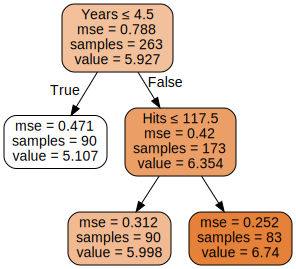

In [20]:
# 図8.1のノートブックへの出力
# out_file=Noneならば結果が文字列で返される
# special_charactersはTrueにするとPostScriptの互換のための特殊文字を無視しない
dot_df = tree.export_graphviz(regr, out_file=None, feature_names=['Years', 'Hits'], filled=True, rounded=True, special_characters=True)  
# dot言語を生で使うにはSourceオブジェクトを使う（https://graphviz.readthedocs.io/en/stable/manual.html）
graph = graphviz.Source(dot_df)  
graph

## 図8.2

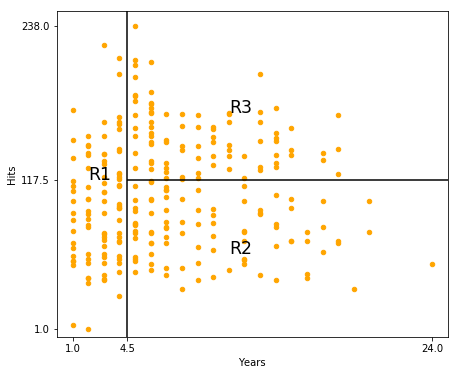

In [28]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(bottom=-5)
# xticksにはticksが配置されるリストを渡す（https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xticks.html）
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

##### 特徴空間の層化による予測

ここで回帰木を作成する過程について学ぶ。大まかに、以下の2つの段階からなる：

Step1: 予測変数空間を分割する。すなわち、$X_1, X_2, \ldots, X_p$のとりうる値の集合を$J$個の重複の無い領域$R_1, R_2, \ldots, R_J$に分割する。

Step2: $R_j$に属する観測値の予測はすべて同じで、単純に$R_j$の訓練データにおける応答変数の平均とする。

どのようにして領域$R_1, \ldots, R_J$を構成すればよいだろうか。理論的には、この領域はどのような形状でもよい。しかしながら、予測モデルを単純にかつその解釈を容易にするために、予測変数空間を高次元の矩形（箱）に分けることにする。よって$R_1, \ldots, R_J$の箱を訓練RSSを最小化するように求める：

\begin{equation}
    \sum_{j=1}^{J}\sum_{i \in R_j}(y_i - \hat{y}_{R_j})^2 \tag{8.1}
\end{equation}

ここで、$\hat{y}_{R_j}$は$j$番目の箱に属する訓練データの応答変数の平均を表す。残念ながら、特徴空間においてとりうるすべての$J$個の箱を考えることは、計算的に実行不可能である。そのため、再帰的な2分割法とよばれるトップダウンな貪欲法を採用する。このアプローチは、木の頂点（すべての観測値が1個の領域に属する点）から始まり、その後次々に予測変数空間を分割するため、トップダウンな方法である。各々の分割は木の下部へ向かって新たに2個の枝を作ることによって示される。また、木を作成する各過程では、先を見通した上で次の段階以降でより良い木になるよう現段階の分割をするのではなく、その特定の段階のみにおける最適な分割が作成されるため、貪欲法と呼ぶことができる。

再帰的な2分割法を実行するには、予測変数$X_j$と分割点$s$を選び、予測変数空間を$\{X|X_j < s\}$と$\{X|X_j \ge s\}$の領域に分ける際、RSSが可能な限り小さくなるようにする。すなわち、すべての予測変数$X_1, \ldots, X_p$、各予測変数におけるすべての分割点の値$s$を考え、RSSが最小となるような木を作成する予測変数と分割点を選ぶ。より詳しくは、すべての$j$と$s$において、半平面の組

\begin{equation}
    R_1(j, s) = \{X|X_j < s\}, R_2(j, s) = \{ X|X_j \ge s \} \tag{8.2}
\end{equation}

を定義し、以下の式
\begin{equation}
    \sum_{i:x_i \in R_1(j, s)}(y_i - \hat{y}_{R_1})^2 + \sum_{i:x_i \in R_2(j, s)}(y_i - \hat{y}_{R_2})^2 \tag{8.3}
\end{equation}
を最小化するような$j$と$s$を探す。ここで、$\hat{y}_{R_1}$は$R_1(j, s)$上の訓練データにおける応答変数の平均、$\hat{y}_{R_2}$は$R_2(j, s)$上の訓練データにおける応答変数の平均である。特に特徴の数$p$がそれほど大きくない場合は、式（8.3）を最小化するような$j$と$s$を求めることは非常に速く行うことができる。

次に、各領域内のRSSを最小化するようなデータの分割を行うために、最適な予測変数と分割点を探しながら、この過程を繰り返す。しかしながら、今回は予測変数空間全体を分割する代わりに、前段階で特定された2個の領域のうちの1個を分割する。このようにして3個の領域を得る。さらにRSSを最小化するように、これらの3個の領域のうちの1個を分割する。この過程は停止条件に達するまで続く。例えば、6個以上の観測値をもつ領域がなくなるまで続ける。

一旦、領域$R_1, \ldots, R_J$が作られれば、テストデータが属する領域の訓練データの平均を用いて、テストデータの応答変数を予測する。

##### 木の刈り込み

上記に提示した過程は、訓練データにおいては良い予測をもたらすものの、過学習しやすくなり、テストデータにおいては機能しなくなってしまう。これは得られた木が複雑すぎるからかもしれない。わずかにバイアスが増加するものの、分割の少ない（すなわち、領域$R_1, \ldots, R_J$の数が少ない）小さな木の方が分散が小さく、また解釈が容易となるであろう。

より良い方法は、まず非常に大きな木$T_0$を成長させ、その後、木を刈り込んで部分木を得ることである。木を刈り込む最適な方法はどのように決めたらよいだろうか。直観的には、テスト誤差を最小にする部分木を得ればよい。部分木が与えられているもとで、交差検証、ホールドアウト検証を用いてテスト誤差を推定する。しかしながら、考えうるすべての部分木において交差検証による誤差の推定を行うことは、部分木の数が莫大であることから、とても困難である。それよりも、考慮する部分木の数を少なくする方法が必要である。

木の複雑さをコスト規準とした刈り込み法は、最弱リンク刈り込み法とも呼ばれ、まさにこれを行うための方法である。すべての部分木を考えるのではなく、非負のチューニングパラメータ$\alpha$を変化させて得られる一連の木のみを考える。各$\alpha$の値において

\begin{equation}
    \sum_{m=1}^{|T|}\sum_{i:x_i \in R_m}(y_i - \hat{y}_{R_m})^2 + \alpha |T| \tag{8.4}
\end{equation}

を可能な限り小さくする部分木$T \subset T_0$がある。ここで、$|T|$は$T$の終端ノードの数、$R_m$は$m$番目の終端ノードに対応する矩形（すなわち、予測変数空間の部分集合）、$\hat{y}_{R_m}$は$R_m$における応答変数の予測値、すなわち$R_m$の訓練データの平均である。チューニングパラメータ$\alpha$は、部分木の複雑さと訓練データへ当てはまりの良さのトレードオフを調整している。$\alpha=0$のときは、式（8.4）は単に訓練誤差を測っているから、部分木$T$は$T_0$と一致する。しかしながら、$\alpha$が増加するにつれて、多くの終端ノードを持つことに対する対価を払うことになり、より小さな部分木において式（8.4）は小さくなる傾向をもつ。式（8.4）の形は、線形モデルの複雑さを調整するために同様の式が用いられるlassoを彷彿とさせる。

式（8.4）において$\alpha$を0から大きくするにつれて枝が刈り込まれる様子は入れ子状で、かつ予想しやすいので、$\alpha$の関数として一連の部分木を得ることは容易である。ホールドアウト検証、あるいは交差検証によって、$\alpha$の値を選択することができる。その後、全データセットに戻って、選択した$\alpha$に対応する部分木を得る。この過程を次にまとめる：

Step1: 再帰的な2分割法を適用して、訓練データにおいて木を大きく成長させる。各終端ノードに含まれる観測値の数がある最小数よりも下回るまで行う。

Step2: 木の複雑さをコスト規準とした刈り込み法を木に適用して、一連の最適な部分木を$\alpha$の関数として得る。

Step3: K分割交差検証を用いて$\alpha$を選ぶ。つまり、訓練データを$k$個に分割して、各$k=1, \ldots, K$に対し
(a)$k$番目を除いた訓練データについて、Step1とStep2を繰り返す。
(b)$\alpha$の関数として、取り除いておいた$k$番目のデータにおけるMSEを評価する。

Step4: Step2にある部分木のリストから、選択した$\alpha$に対応する部分木を出力する。

In [1]:
# 刈り込みはscikit-learnでは現在サポートされていない（https://scikit-learn.org/dev/modules/tree.html）

### 分類木

分類木は、量的な応答変数ではなく質的な応答変数を予測する点を除いて、回帰木と極めて類似している。回帰木における観測対象の応答変数の予測値は、同じ終端ノードに属する訓練データの応答変数の平均値で与えられていた。これに対して、分類木においては、各観測値は領域内の訓練データの最も頻度の高いクラスに属していると予測される。分類木を解釈する際、ある特定の終端ノードの領域に対するクラスの予測だけでなく、その領域に属する訓練データの各クラスの比率にも関心が及ぶことがある。

分類木を大きく成長させることは、回帰木を大きく成長させることとまったく同様である。回帰の場合のように、分類木を成長させるためには再帰的な2分割法を用いる。しかしながら、分類木の場合は、分割を行う際の規準としてRSSを用いることはできない。RSSに代わる自然な規準は誤分類率である。観測値を属する領域の訓練データの最も頻度の高いクラスに割り当てるため、誤分類率はその領域において単に最も多いクラスに属さない訓練データの比率である。つまり、

\begin{equation}
    E = 1 - \max_k(\hat{p}_{mk})
\end{equation}

である。ここで$\hat{p}_{mk}$は$m$番目の領域における訓練データのうち、$k$番目のクラスの比率を表す。しかしながら、誤分類率は木を成長させる上では十分な感度を持たない。実用上は以下の2つの尺度の方が好ましいとされる。

ジニ係数は
\begin{equation}
    G  = \sum_{k=1}^{K} \hat{p}_{mk} (1 - \hat{p}_{mk}) \tag{8.6}
\end{equation}

によって定義され、全Kクラス間の総分散を表す尺度である。すべての$\hat{p}_{mk}$が0または1に近い値をとると、ジニ係数は小さい値をとることは容易にわかる。このため、ジニ係数はノードの純度に対する尺度として用いられる。つまり、小さい値であることは、ほとんどの観測値が同じクラスに属しているノードであることを表す。

ジニ係数に代わるものとして、エントロピー

\begin{equation}
    D = - \sum_{k=1}^{K} \hat{p}_{mk} \log \hat{p}_{mk} \tag{8.7}
\end{equation}

がある。$0 \le \hat{p}_{mk} \le 1$より、$0 \le - \hat{p}_{mk}\log \hat{p}_{mk}$が成立する。すべての$\hat{p}_{mk}$が$0$または$1$に近い値をとるとき、エントロピーは$0$に近い値となる。そのため、ジニ係数のように、$m$番目のノードの純度が高ければ、エントロピーもまた小さな値をとることになる。事実、ジニ係数とエントロピーは極めて近い値をとる。

分類木を作成するとき、ジニ係数やエントロピーはノードの純度に関する感度が誤分類率よりも良いため、分割の質を評価するには通常これら2つのどちらかの方法が用いられる。しかし、最終的に予測精度が良くなるように木を刈り込みたい場合は、誤分類率を用いることが好ましい。

In [5]:
df2 = pd.read_csv('Datasets/Heart.csv')
df2.head(3)

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [11]:
# 「Unnamed: 0」列を削除する
# pandas.drop()はインプレースではない（コピーを作って返す）
df2 = df2.drop('Unnamed: 0', axis=1).dropna()
df2.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [12]:
# pandas.factorizeはカテゴリ変数をユニークな数値に変換し、labels:ndarrayとuniques:ndarrayを返す。返り値の後者には元のカテゴリが入っている。
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [13]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [34]:
# max_featuresは各分割において考慮する特徴の数
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=12)
clf.fit(X2,y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=12, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [35]:
# mean accuracyを計算
clf.score(X2,y2)

0.8181818181818182

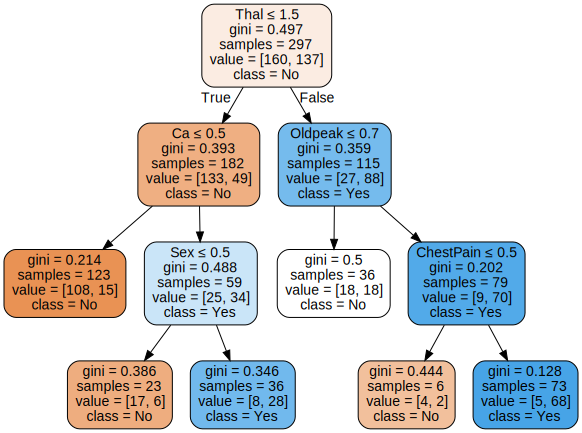

In [36]:
dot_df2 = tree.export_graphviz(clf, out_file=None, feature_names=X2.columns, class_names=['No', 'Yes'], filled=True, rounded=True, special_characters=True)
graph2 = graphviz.Source(dot_df2)  
graph2

### 木と線形モデルの比較

回帰木や分類木は、（線形回帰やロジスティック回帰などの）回帰や分類の古典的なアプローチとはとても異なる色合いをもつ。特に線形回帰はモデルの形式として

\begin{equation}
    f(X) = \beta_0 + \sum_{j=1}^p X_j \beta_j \tag{8.8}
\end{equation}

を仮定している一方、回帰木はモデルとして

\begin{equation}
    f(X) = \sum_{m=1}^M c_m \cdot 1_{(X \in R_m)} \tag{8.9}
\end{equation}

の形式を仮定している。ここで$R_1, \ldots, R_M$は特徴空間の分割を表している。

どちらのモデルの方が良いだろうかは問題ごとに異なる。予測変数と応答変数の関係が式（8.8）でみられるような線形モデルでよく近似できる場合は、線形回帰のようなアプローチがよく機能し、この線形構造を利用しない回帰木のような方法よりも優るであろう。逆に、式（8.9）で示されているように、予測変数と応答変数の間に非線形で複雑な関係が強い場合は、決定木が古典的アプローチを凌駕するであろう。木に基づくアプローチと古典的なアプローチの相対的な性能の差は、交差検証またはホールドアウト検証によるアプローチを使ってテスト誤差を推定することによって評価することができる。

もちろん、統計的学習の方法を選択するに当たって、単純なテスト誤差以上に、他に考慮がなされることがあるかもしれない。例えば、ある設定の下では、解釈のしやすさや可視化の目的のため、木を使った予測が好まれるかもしれない。

### 木の利点と欠点

回帰や分類における決定木は、古典的なアプローチに対し、多くの利点を持っている。

pros:
- 木はその結果を説明することが非常に容易である。実際、線形回帰よりも説明が容易である。
- 決定木による方法は、前出の章でみられる回帰や分類のアプローチよりも人間の意志決定をよりよく反映していると考える人もいる。
- 木は非常に視覚的であり、専門家でなくても（特に小さい木であれば）解釈が容易である。
- 木は、ダミー変数を作成することなく質的な予測変数を容易に扱うことができる。

cons:
- 残念ながら、一般的に、木による方法はいくつかの他の回帰や分類のアプローチと同程度の予測精度を保つことができない。
- さらに、木はロバストさに欠ける。つまり、データが少し変化した際、木が大きく変化してしまう場合がある。


（consについて）しかしながら、バギング、ランダムフォレスト、ブースティングのような方法を用いて、多くの決定木を集めることにより、木の予測の性能を十分に改良することができる。

## バギング、ランダムフォレスト、ブースティング 

### バギング

ブートストラップは非常に強力なアイディアである。ブートストラップは、関心の対象となる量の標準偏差を直接計算することが難しい、あるいは不可能である多くの場合において利用される。ここでは、決定木のような統計的学習法を改良するために、ブートストラップをまったく異なる状況で用いる。

決定木には、分散が大きくなるという難点がある。これは、訓練データをランダムに2つに分割して両方に決定木を当てはめると、得られる結果が大きく異なることもあるということである。これに対して、分散が小さい方法は繰り返し別のデータセットに適用したとしても同様の結果を得るであろう。線形回帰は、$p$に対する$n$の比が適度に大きくなっていれば分散が小さくなる傾向にある。バギング（bagging: bootstrap aggregation）は、統計的学習法の分散を減少させる汎用的な方法である。バギングは決定木において特に有用であり、また頻繁に用いられる。

分散$\sigma^2$の$n$個の独立な観測値$Z_1, \ldots, Z_n$が得られた下では、観測値の平均値$\bar{Z}$の分散は$\sigma^2 / n$となることを再度確認されたい。言い換えれば、観測値の平均は分散を小さくするということである。このように、分散を小さくし、統計的学習法の予測精度を上げるための自然な方法は、母集団から多くの訓練データを得て、各訓練データを用いて別々に予測モデルを構築し、それらの予測を平均することである。言い換えれば、$B$個の異なる訓練データセットを用いて$\hat{f}^1(x), \hat{f}^2(x), \ldots, \hat{f}^B(x)$を計算し、それらを平均して

\begin{equation}
    \hat{f}_{avg}(x) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}^b(x)
\end{equation}

により分散が小さい統計的学習モデルを得る。もちろんこれは実用的ではない。なぜなら、通常、複数の訓練データセットを得ることはないからである。その代わり、1つの訓練データセットから繰り返し標本を抽出するブートストラップを実行することができる。このアプローチによって、$B$個の異なるブートストラップ訓練データセットを生成することができる。$b$番目のブートストラップデータセットでこの方法を学習し、$\hat{f}^{*b}(x)$を得る。最終的にすべての予測モデルを平均化し

\begin{equation}
    \hat{f}_{avg}(x) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}^{*b}(x)
\end{equation}

を得る。これがバギングである。

多くの回帰の方法においてバギングはその予測を改良することができるが、決定木においては特に有用である。回帰木にバギングを適用するためには、$B$個のブートストラップ訓練データを用いて、単に$B$個の回帰木を構成し、それぞれの予測を平均する。これらの木は伸長しており、刈り込みがされていない。したがって、それぞれの木は分散が大きくバイアスは小さい。$B$個の木を平均することによって、分散を小さくする。バギングは、数百個、さらには数千個もの気をまとめることにより、精度が劇的に向上することがわかっている。

これまで、量的な応答変数$Y$を予測する回帰問題において、バギングの方法を示してきた。どのようにすれば$Y$が質的変数である分類問題にバギングを拡張できるであろうか。この場合はいくつかの方法があるが、もっとも単純な方法は以下のとおりである。与えられたテストデータにおいて、$B$個の期のそれぞれによって予測されたクラスを記録し、多数決をとる。つまり、$B$個のモデルのうちで最も多く予測されたクラスを全体的な予測とするのである。

バギングにおいては、木の数$B$は重要なパラメータではない。つまり、非常に大きな$B$を用いたとしても、過学習を引き起こすものではない。実用上、木の数$B$の関数としてテスト誤分類率を表したときに誤分類率が安定する程度の十分大きな$B$の値を採用する。

#### Out-of-bag(OOB)による誤分類率の推定

バギングして得られたモデルのテスト誤分類率を推定するのに、交差検証やホールドアウト検証を用いないとても簡単な方法が存在する。バギングの重要な点は、観測値のブートストラップ標本に対し木の当てはめを繰り返して行うことである。バギングで得られた各々の木は、平均的に観測値の約3分の2を用いて得られている。残りの3分の1の観測値はバギングに用いられず、これらはout-of-bag(OOB)観測値と呼ばれる。第$i$番目の観測値の応答変数を予測するのに、その観測値がOOBとなる木を使って予測する。これにより、第$i$観測値には、およそ$B / 3$個の予測値を与える。これらの予測値をまとめるには、回帰であれば平均を算出すればいいし、分類であれば多数決をとればよい。これが第$i$観測値におけるOOBによる予測である。このようにして$n$個の各観測値においてOOBによる予測を得ることができる。さらにそれを使い全体的な（回帰問題においては）OOB平均2乗誤差、または（分類問題においては）OOB誤分類率を計算することができる。各観測値の応答変数は、その観測値を用いずに当てはめた木を用いて予測されているので、OOB誤差はバギングで得られたモデルのテスト誤差の妥当な推定となっている。$B$が十分に大きいとき、OOB誤差は実質的にLOOCV誤差と同等であることが分かっている。大規模なデータセットにおいてバギングを行う際には、テスト誤差を推定するのに交差検証では計算上の負担が大きくなるため、OOBのアプローチは特に有用である。

#### 変数選択規準

これまで見てきたように、一般的にバギングでは1つの木のみを用いた予測よりも制度に改良がみられる。しかしながら、残念なことに、その得られたモデルの解釈が困難な場合がある。決定木の1つの利点は、見栄えがよく簡単に理解できる図である。しかし、多くの木をバギングしたとき、もはや1つの木で統計的学習の結果を表すことはできなくなり、その方法においてどの変数が最も重要であるかも明確でなくなってしまう。このように、バギングは結果の解釈のしやすさを犠牲にして、予測精度の向上を行っている。

バギングによって得られた多くの木は、1つの木よりも解釈がより困難となるが、（回帰木におけるバギングでは）RSSまたは（分類木におけるバギングでは）ジニ係数を用いて、各予測変数の重要度を得ることができる。回帰木のバギングの場合は、ある予測変数の分割によって、式（8.1）のRSSがいくら減少するかを計算し、$B$個の木について平均する。この値が大きければその変数は重要であるということである。同様に、分類木のバギングにおいても、ある予測変数の分割によって、ジニ係数（8.6）がいくら減少したかを求め、これらを$B$個の木について平均すればよい。

### ランダムフォレスト

ランダムフォレストは、木を無相関にするためのわずかな調整を行うことにより、バギングで得られた木を改良するものである。バギングの場合と同様、ブートストラップで得られた訓練データにおいて多くの決定木を作ることになる。しかし、これらの決定木を作るとき、木を分割する度に、$p$個の全予測変数から分割の候補として、$m$個のランダムサンプルが選ばれる。分割には、$m$個の予測変数のうち1つが用いられる。分割する度に新たに$m$個の予測変数サンプルが選ばれ、一般に$m$の値として$m \approx \sqrt{p}$が用いられる。すなわち、各分割において考慮する予測変数の数はおおよそ全予測変数の数の平方根と等しい。

言い換えれば、ランダムフォレストを作る際、木の各分割において、アルゴリズムは大多数の予測変数について考慮さえもさせてもらえないのである。これは奇妙に思えるかもしれないが、よく考えると納得できる理論的根拠がある。データセットにおいてとても有用な予測変数が1つあり、他の多くは適度に有用であるとする。このとき、バギングした木のうち、多くの、あるいはすべての木はこの有用な予測変数を最初の分割で用いるであろう。その結果、バギングした木はすべて極めて類似している木となる。このため、バギングした木から得られる予測は相関がとても高くなる。残念ながら、高い相関を持つ量を平均することは、無相関な量を平均した場合ほどの分散の減少には繋がらない。特に、この設定の下では、バギングが1つの木と比べて分散を減らすことにつながらないことを意味している。

ランダムフォレストは、各分割において予測変数の一部のみを検討することによってこの問題を解決する。したがって、平均的に分割の$(p-m)/p$はこの強力な予測変数を考慮さえもしないことになり、他の予測変数が用いられる機会が多くなる。この過程を木の無相関化として考え、それによって得られた気の平均はばらつきが小さくなり、より信頼性をもつことになる。

バギングとランダムフォレストの主な違いは、$m$個の予測変数を選ぶ点にある。例えば、ランダムフォレストが$m=p$において行われた場合、これは単にバギングとなる。

多くの予測変数に相関があるときには、ランダムフォレストにおいて$m$に小さな値を用いることが有用である。また、バギングと同様$B$が増えたとしても、ランダムフォレストは過学習とはならない。したがって、実用上は誤分類率が安定する程度の十分大きな$B$を採用する。

### ブースティング

バギングと同様、ブースティングは一般的なアプローチであり、回帰や分類に関する多くの統計的学習法に適用可能である。ここでは、決定木におけるブースティングに限定する。

バギングは、オリジナルの訓練データから多くのブートストラップ標本を作成し、各ブートストラップ標本に別々の決定木を当てはめ、すべての木を組み合わせて1つの予測モデルを作る。とりわけ、各々の木はブートストラップ標本に基づいて作成され、他の木とは独立している。ブースティングはこれと同様の方法であるが、ただ木が順次段階的に成長していく点が異なる。つまり、各々の木は前段階での木の情報を用いて成長する。ブースティングでは、ブートストラップを使わない代わりに、各々の木はオリジナルデータの修正版に当てはめられる。

最初に回帰の問題を考える。バギングと同様、ブースティングは多くの決定木$\hat{f}^1, \ldots, \hat{f}^B$を組み合わせる。ブースティングのアルゴリズムを次に示す：

Step1: $\hat{f}(x) = 0$とし、訓練データセットのすべての$i$において$r_i = y_i$とする。

Step2: $b = 1, 2, \ldots, B$において、以下を繰り返す：

    (a)訓練データ$(X, r)$に対し、$d$個の分割（$d+1$個の終端ノード）をもつ木$\hat{f}^b$を当てはめる。
    
    (b)新しい木の縮小版を加えることにより、$\hat{f}$を更新する：

\begin{equation}
\hat{f}(x) \gets \hat{f}(x) + \lambda \hat{f}^b(x) \tag{8.10}
\end{equation}
    
    (c)残差を更新する：
\begin{equation}
r_i \gets r_i - \lambda \hat{f}^b(x) \tag{8.11}
\end{equation}

Step3: ブースティングで得られたモデル
    \begin{equation}
       \hat{f}(x) = \sum_{b=1}^B \lambda \hat{f}^b(x) \tag{8.12}
    \end{equation}
    を出力する。
    
この方法の背後にある概念はどのようなものか。データに1つの大きな決定木を当てはめた場合、データにしっかりと当てはめることで過学習を起こしてしまう可能性がある。ブースティングはそれを避けるように緩やかに学習を行う。現在のモデルが与えられた下で、その残差に決定木を当てはめる。すなわち、出力変数$Y$ではなく現在のモデルの残差を応答変数として木の当てはめに用いるのだ。そして、当てはめた関数に新しい決定木を加えて残差を更新する。これらの木は、アルゴリズム上のパラメータ$d$によって定められる少数の終端ノードをもつ小さな木となる。小さな木を残差に当てはめることにより、あまり性能が良くない場所において徐々に$\hat{f}$を改良する。縮小パラメータ$\lambda$はさらにその過程を遅らせるため、より多くの異なる形の木が残差に当てはめられる。一般的に、統計的学習法は緩やかに学習を行うと性能が良くなる傾向にある。ブースティングでは、バギングと異なり、各々の木がどのような構成になるかはそれ以前にできた木に強く依存している。

ブースティングは3つのチューニングパラメータをもつ：

1. $B$は木の数である。バギングやランダムフォレストとは異なり、ブースティングは$B$が大きすぎると過学習となる。仮に過学習になるとしても、緩やかに過学習となる。$B$を選ぶ際は交差検証が用いられる。
2. 縮小パラメータ$\lambda$は、小さな正の数である。これはブースティングの学習速度を調整する。通常用いられる値は$0.01$または$0.001$であり、適切な選び方はその問題による。よい性能を得るためには、$\lambda$を小さくする場合、$B$を大きくする必要がある。
3. 各々の木における分割数$d$はブースティングの全体的な複雑さを調整する。たいていの場合$d=1$がよく機能する。その場合、各々の木が1つの分割のみからなる切り株である。この場合、各項が1つの変数のみを含むことから、ブースティング全体としては加法モデルの当てはめとなる。$d$個の分割は最も多くて$d$個の変数を含めることができるから、より一般的には$d$は交互作用に関わる変数の数であり（交互作用の「深さ」とも呼ばれる）、ブースティングで得られたモデルの交互作用の次数を調整するものである。

## 実習：決定木 

### 分類木の当てはめ

In [41]:
df3 = pd.read_csv('Datasets/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


In [42]:
type(df3.Sales)

pandas.core.series.Series

In [43]:
# Salesは連続変数なので、これを2値変数に符号化し直す
# pandas.mapはSeriesの各要素に関数を適用しコピーを返すが、これを使ってHighという変数をつくる
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1


In [44]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null int64
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null int64
US             400 non-null int64
High           400 non-null int64
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [45]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [46]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [47]:
# http://ibisforest.org/index.php?F%E5%80%A4
# supportはtrueの各クラスに属するデータ数（https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support）
# macro avgは単純な縦の平均、weighted avgはサンプルサイズで重みを付けた平均
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93       236
           1       0.98      0.82      0.89       164

   micro avg       0.92      0.92      0.92       400
   macro avg       0.93      0.90      0.91       400
weighted avg       0.92      0.92      0.92       400



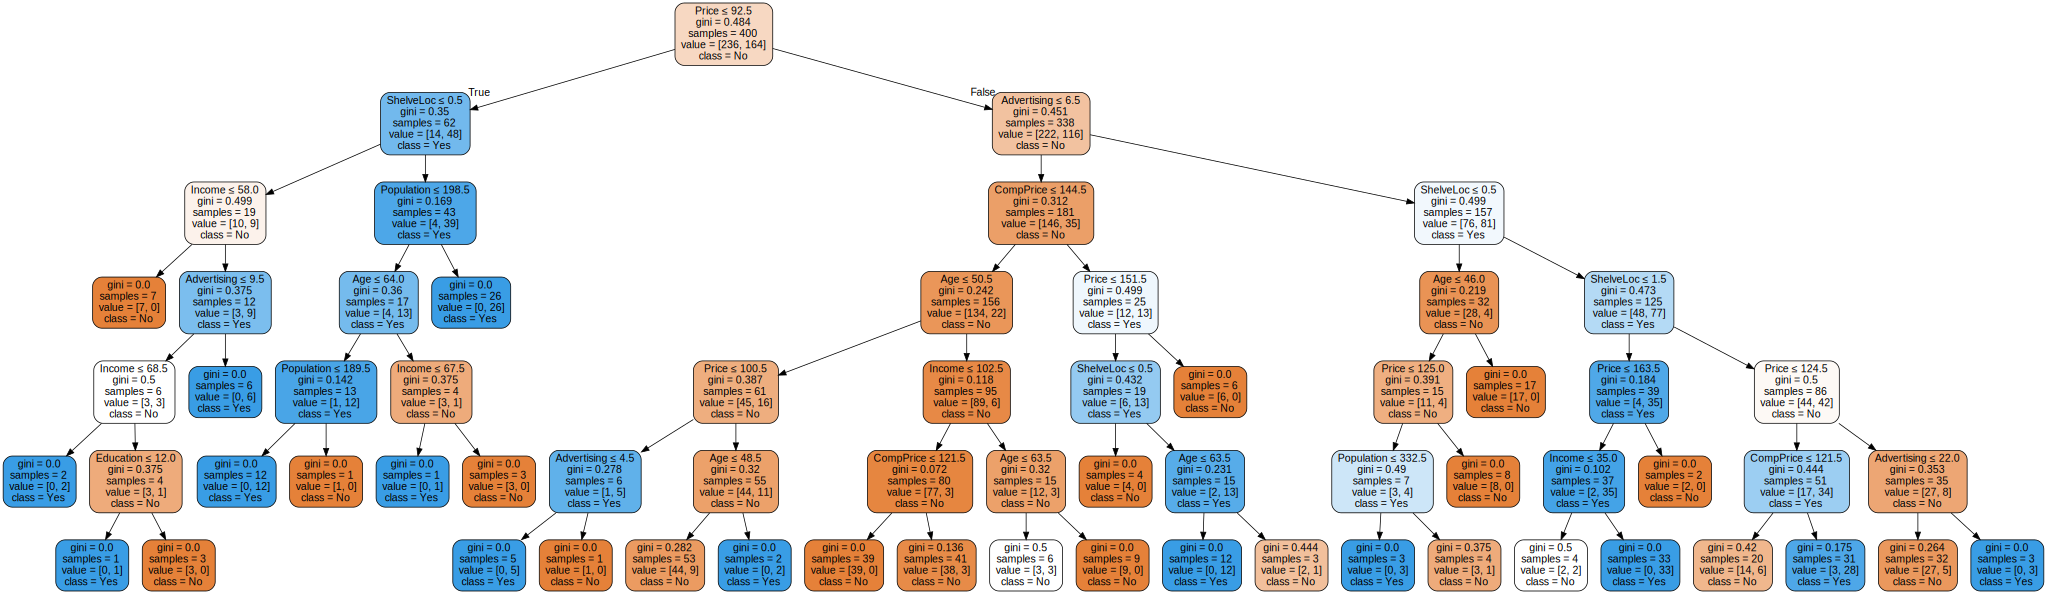

In [48]:
dot_df3 = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True, special_characters=True)
graph3 = graphviz.Source(dot_df3)
graph3
# 最初の枝はPriceを分割していることから、Salesにおける最も重要な指標は価格であると思われる

In [49]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [50]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,99,32
Yes,19,50


In [51]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       118
           1       0.72      0.61      0.66        82

   micro avg       0.74      0.74      0.74       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.74      0.74      0.74       200



### 回帰木の当てはめ

In [52]:
df4 = pd.read_csv('Datasets/Boston.csv').drop('Unnamed: 0', axis=1)
df4.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


In [53]:
X = df4.drop(['medv'], axis=1)
y = df4.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [54]:
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

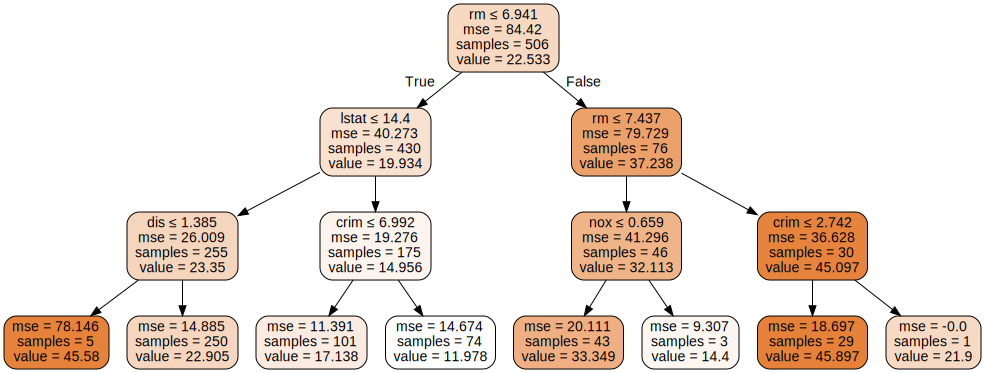

In [55]:
dot_df4 = tree.export_graphviz(regr, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)  
graph4 = graphviz.Source(dot_df4)  
graph4

In [56]:
regr.fit(X_train, y_train)
pred = regr.predict(X_test)

Text(0, 0.5, 'y_test')

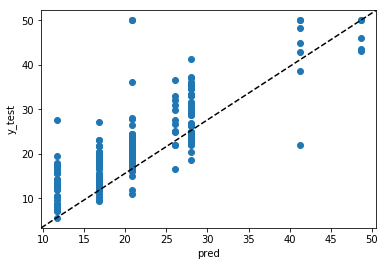

In [57]:
plt.scatter(pred, y_test, label='medv')
# 軸に関するテキスト（直線）の挿入（https://www.machinelearningplus.com/plots/matplotlib-tutorial-complete-guide-python-plot-examples/）
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [58]:
print(mean_squared_error(y_test, pred))

26.02323085009744


### バギングとランダムフォレスト

In [73]:
# n_estimatorsは木の数（B）であるが、100とする
# max_featuresは分割の際考慮する変数の数であるが、sqrt(13) \approx 3.6より4とする（デフォルトは=n_featuresつまりバギングになっている）
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
regr2 = RandomForestRegressor(n_estimators=100, max_features=4, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [74]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

15.767134932806325

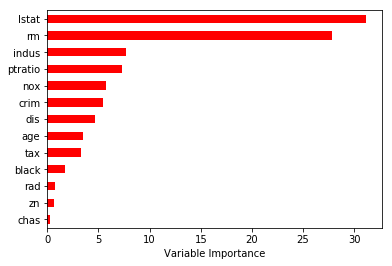

In [75]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### ブースティング

In [78]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

zn          0.010346
chas        0.121257
rad         0.150597
black       0.459114
indus       0.497222
nox         0.791744
age         0.880128
tax         1.108479
crim        2.684293
ptratio     4.452571
dis         5.987496
rm         27.934650
lstat      54.922104
dtype: float64


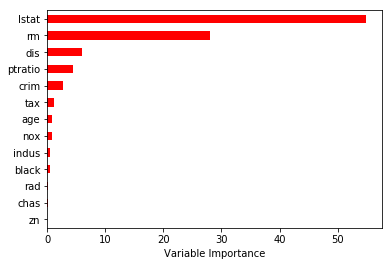

In [79]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## Reference

- 落海浩，首藤信通．Rによる統計的学習入門．朝倉書店，2018，403p．
- https://github.com/JWarmenhoven/ISLR-python